In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install pyg-lib -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html

2.3.0+cu121
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 3.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-cxdmvrg7
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-cxdmvrg7
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 4e01b0bca72e97aca2ec0e1edf27ec768dc16d8a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.6.0-py3-none-any.whl size=1119024 sha256=c49069452606b33dbe1fbe9f738aa7c8cdcbcc7864d50458f600aa1a8e0b772e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mo28pl83/wheels/d3/78/eb/9e26525b948d19533f1688fb6c209cec8a0ba793d39b49ae8f
Successfully built torch-geometric
  Attempting uninstall: torch-geometric
  

In [ ]:
import numpy as np
import os
import scipy
import scipy.io
import os.path as osp
from torch_geometric.data import Data
import torch
from gensim.models import Word2Vec, KeyedVectors
import torch_geometric.transforms as T
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
import networkx as nx
import torch.nn as nn

In [ ]:
# connected to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_humloc(data_name="HumanGo", path='/content/drive/My Drive/data'):
  edge_list = torch.tensor(np.genfromtxt(os.path.join(path, data_name, "edge_list.csv"),
                                          skip_header=1, dtype=np.dtype(float), delimiter=','))[:, :2].long()
  edge_list_other_half = torch.hstack((edge_list[:, 1].reshape(-1, 1), edge_list[:, 0].reshape(-1, 1)))
  edge_index = torch.transpose(edge_list, 0, 1)
  edge_index_other_half = torch.transpose(edge_list_other_half, 0, 1)
  edge_index = torch.hstack((edge_index, edge_index_other_half))

  labels = np.genfromtxt(os.path.join(path, data_name, "labels.csv"),
                          dtype=np.dtype(float), delimiter=',')
  labels = torch.tensor(labels).float()

  features = torch.tensor(np.genfromtxt(os.path.join(path, data_name, "features.csv"),
                          dtype=np.dtype(float), delimiter=',')).float()

  file_path = os.path.join(path, data_name, "split.pt")
  masks = torch.load(file_path)
  train_idx = masks["train_mask"]
  train_mask = torch.zeros(features.shape[0], dtype=torch.bool)
  train_mask[train_idx] = True

  val_idx = masks["val_mask"]
  val_mask = torch.zeros(features.shape[0], dtype=torch.bool)
  val_mask[val_idx] = True

  test_idx = masks["test_mask"]
  test_mask = torch.zeros(features.shape[0], dtype=torch.bool)
  test_mask[test_idx] = True

  G = Data(x=features,
            edge_index=edge_index,
            y=labels)
  G.train_mask = train_mask
  G.val_mask = val_mask
  G.test_mask = test_mask
  G.num_nodes = G.x.shape[0]
  G.n_id = torch.arange(G.num_nodes)
  return G

In [ ]:
HumLoc = load_humloc(data_name="HumanGo", path='/content/drive/My Drive/data')
HumLoc

Data(x=[3106, 32], edge_index=[2, 36992], y=[3106, 14], train_mask=[3106], val_mask=[3106], test_mask=[3106], num_nodes=3106, n_id=[3106])

In [ ]:
#reading EukaryoteGo
edge_index = HumLoc.edge_index
G_HumLoc = nx.Graph()
nodes = list(range(HumLoc.num_nodes))
G_HumLoc.add_nodes_from(nodes)
edges = edge_index.t().tolist()  # 转置并转换为 Python 列表
G_HumLoc.add_edges_from(edges)
print("Number of nodes:", G_HumLoc.number_of_nodes())
print("Number of edges:", G_HumLoc.number_of_edges())

Number of nodes: 3106
Number of edges: 16508


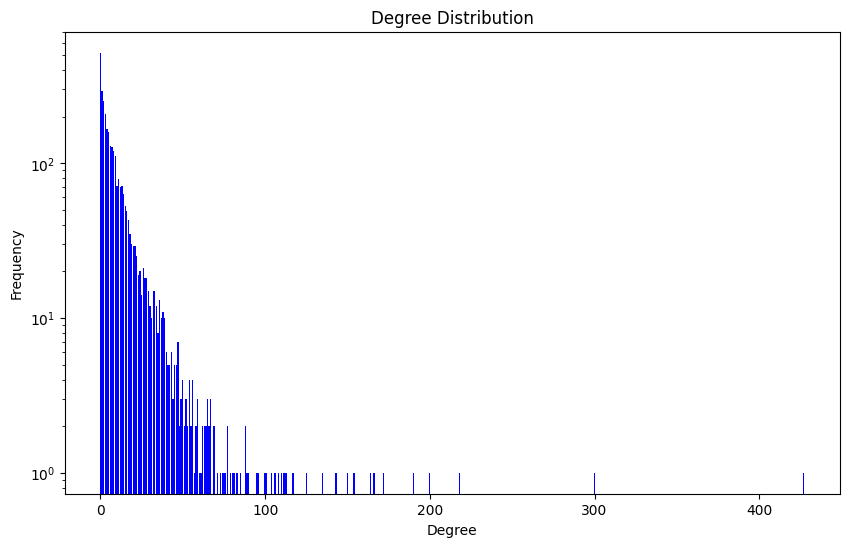

In [62]:
# 2. 计算每个节点的度
degrees = [G_HumLoc.degree(n) for n in G_HumLoc.nodes()]

# 3. 统计每个度出现的频率
degree_counts = {}
for degree in degrees:
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# 4. 分离度和值
degree_values = list(degree_counts.keys())
counts = list(degree_counts.values())

# 5. 绘制度分布图
plt.figure(figsize=(10, 6))
plt.bar(degree_values, counts, width=0.8, color='b')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')  # 如果需要，可以将y轴设为对数尺度

plt.show()

In [ ]:
#Spliting EukaryoteGo into largest connected component and remaining
largest_cc = max(nx.connected_components(G_HumLoc), key=len)
largest_subgraph = G_HumLoc.subgraph(largest_cc)
# 打印节点和边的数量
print("Number of nodes-lcc:", largest_subgraph.number_of_nodes())
print("Number of edges-lcc:", largest_subgraph.number_of_edges())
G_remaining = G_HumLoc.copy()
# 移除 G1 中的所有节点
G_remaining.remove_nodes_from(largest_subgraph.nodes)
# 移除 G1 中的所有边
G_remaining.remove_edges_from(largest_subgraph.edges)
print("Number of nodes-remaining:", G_remaining.number_of_nodes())
print("Number of edges-remaining:", G_remaining.number_of_edges())

Number of nodes-lcc: 2552
Number of edges-lcc: 16472
Number of nodes-remaining: 554
Number of edges-remaining: 36


In [ ]:
# support = 0.0
# label_classes = []
# for edge in edges:
#     support = support + jaccard_score(labels[edge[0]].numpy(),
#                                       labels[edge[1]].numpy())
#     edge_0_label = find_occurance_class(labels[edge[0]].numpy())
#     edge_1_label = find_occurance_class(labels[edge[1]].numpy())

# h = support / len(edges)
# print(h)

In [ ]:
#计算largest connected component中的label homophily
labels = HumLoc.y
support = 0.0
label_classes_lcc = []
for edge in list(largest_subgraph.edges):
    support = support + jaccard_score(labels[edge[0]].numpy(),
                                      labels[edge[1]].numpy())

#不能从边上找出现过的label类，要从节点上找，因为很多节点是孤立的
h = support / largest_subgraph.number_of_edges()
print(h)

0.4161243322000958


In [ ]:
#计算remaining graph中的label homophily
support = 0.0
for edge in list(G_remaining.edges):
    support = support + jaccard_score(labels[edge[0]].numpy(),
                                      labels[edge[1]].numpy())

h = support / G_remaining.number_of_edges()
print(h)

#many self loops, 信息缺失

0.875


In [ ]:
# 计算聚类系数（clustering coefficient）
clustering_coeff = nx.average_clustering(largest_subgraph)
# 计算链接密度（link density）
link_density = nx.density(largest_subgraph)
print(f"聚类系数: {clustering_coeff}")
print(f"链接密度: {link_density}")

聚类系数: 0.13209254810830082
链接密度: 0.005060404119596593


In [ ]:
clustering_coeff = nx.average_clustering(G_HumLoc)
# 计算链接密度（link density）
link_density = nx.density(G_HumLoc)
print(f"聚类系数: {clustering_coeff}")
print(f"链接密度: {link_density}")

聚类系数: 0.10853193263759937
链接密度: 0.003423429588775763


In [ ]:
def print_dataset_label_statistic(labels):
    # 计算每行的非零元素个数
    nonzero_counts = torch.count_nonzero(labels, dim=1)

    # 转换为浮点数类型，以便进行平均值计算
    nonzero_counts_float = nonzero_counts.float()

    # 计算非零元素个数的最小值、平均值、中位数和最大值
    min_count = torch.min(nonzero_counts).item()
    mean_count = torch.mean(nonzero_counts_float).item()
    median_count = torch.median(nonzero_counts.float()).item()
    max_count = torch.max(nonzero_counts).item()

    # 打印结果
    print("每行非零元素个数的最小值:", min_count)
    print("每行非零元素个数的平均值:", mean_count)
    print("每行非零元素个数的中位数:", median_count)
    print("每行非零元素个数的最大值:", max_count)

In [ ]:
# 最大连通量的label分布
selected_labels_largest_cc = labels[torch.tensor(list(largest_cc))]
print_dataset_label_statistic(selected_labels_largest_cc)

每行非零元素个数的最小值: 1
每行非零元素个数的平均值: 1.1939655542373657
每行非零元素个数的中位数: 1.0
每行非零元素个数的最大值: 4


In [ ]:
# 最大连通量的label分布
selected_labels_remaining = labels[torch.tensor(list(G_remaining.nodes))]
print_dataset_label_statistic(selected_labels_remaining)

每行非零元素个数的最小值: 1
每行非零元素个数的平均值: 1.1444042921066284
每行非零元素个数的中位数: 1.0
每行非零元素个数的最大值: 4


In [ ]:
def find_columns_with_ones(tensor):
    num_rows, num_cols = tensor.shape
    columns_with_ones = set()

    for row_idx in range(num_rows):
        row = tensor[row_idx]
        indices = np.where(row == 1)[0]  # 找到每行中值为1的索引
        columns_with_ones.update(indices)  # 将索引添加到集合中
    return list(columns_with_ones)

In [ ]:
columns_count_lcc = find_columns_with_ones(selected_labels_largest_cc)
print("Columns with ones count-lcc:")
columns_count_lcc

Columns with ones count-lcc:


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [ ]:
columns_count_remaining = find_columns_with_ones(selected_labels_remaining)
print("Columns with ones count-remaining:")
columns_count_remaining

Columns with ones count-remaining:


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

From this we infer that most of topology information and classes information has been covered by largest connected components

Now we will use the topology information from largest connected component and some adding nodes from the remaining class (so the model can identify this kind of class)

In [ ]:
#only modifying training_mask, 对training_mask做进一步挑选，挑选出只在largest connected component 出现过的节点
def update_train_mask(train_mask, node_list):
    node_set = set(node_list)  # 将node_list转换为集合以便快速查找
    updated_mask = train_mask.clone()  # 复制 train_mask，以免修改原始数据
    for idx in range(train_mask.size(0)):
        if updated_mask[idx] and idx not in node_set:
            updated_mask[idx] = False
    return updated_mask

# 示例用法
# 假设 Euka.train_mask 是一个 PyTorch 张量，largest_cc 是一个列表
train_mask_lcc = update_train_mask(HumLoc.train_mask, list(largest_cc))
train_mask_lcc

tensor([ True,  True,  True,  ..., False, False, False])

In [ ]:
train_mask = HumLoc.train_mask
test_mask = HumLoc.test_mask
def count_true_values(tensor):
    return tensor.sum().item()
true_count_lcc = count_true_values(train_mask_lcc)
print("Number of True values:", true_count_lcc)
true_count_original = count_true_values(train_mask)
print("Number of True values:", true_count_original)
#训练数据大幅度缩减

Number of True values: 1366
Number of True values: 1675


In [ ]:
HumLoc

Data(x=[3106, 32], edge_index=[2, 36992], y=[3106, 14], train_mask=[3106], val_mask=[3106], test_mask=[3106], num_nodes=3106, n_id=[3106])

In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import SAGEConv
# for mini-batch training
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import Node2Vec
# For GraphSage
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(HumLoc.x.shape[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, HumLoc.y.shape[1])

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

class GAT(nn.Module):
    def __init__(self, hidden_channels, num_heads, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(HumLoc.x.shape[1], hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, HumLoc.y.shape[1], heads=num_heads, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, class_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, class_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
        return F.sigmoid(x)

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
            x_all = torch.cat(xs, dim=0)
        return F.sigmoid(x_all)



In [ ]:
# decide what kind of model you would like to use
#GCN
model_lcc = GCN(hidden_channels=32)
#GAT
hidden_channels = 32
num_heads = 2
gat_model_lcc = GAT(hidden_channels, num_heads)
#Graph SAGE
model_SAGE_lcc = SAGE(in_channels=HumLoc.x.shape[1],
                 hidden_channels=32,
                 class_channels=HumLoc.y.shape[1],
                 )

In [ ]:
optimizer = torch.optim.Adam(gat_model_lcc.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Training function
from metrics import f1_loss,_eval_rocauc,ap_score

def train_lcc(model_lcc):
    model_lcc.train()
    optimizer.zero_grad()
    out = model_lcc(HumLoc)
    loss = criterion(out[train_mask_lcc], HumLoc.y[train_mask_lcc])
    loss.backward()
    optimizer.step()
    return loss

def train_lcc_enrich(model_lcc_enrich):
    model_lcc_enrich.train()
    optimizer.zero_grad()
    out = model_lcc_enrich(HumLoc)
    loss = criterion(out[train_mask_lcc_enriching], HumLoc.y[train_mask_lcc_enriching])
    loss.backward()
    optimizer.step()
    return loss

def train_normal(model_normal):
    model_normal.train()
    optimizer.zero_grad()
    out = model_normal(HumLoc)
    loss = criterion(out[train_mask], HumLoc.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss

# Testing function
def test(model):
    model.eval()
    out = model(HumLoc)
    true_labels = HumLoc.y[test_mask]
    micro_f1,macro_f1 = f1_loss(true_labels, out[test_mask])
    macro_AUC_ROC = _eval_rocauc(true_labels, out[test_mask])
    ap_score_1 = ap_score(true_labels, out[test_mask])
    return micro_f1,macro_f1,macro_AUC_ROC,ap_score_1

In [ ]:
def train_GraphSage(model, loader):
  model.train()
  total_loss = 0
  for data in loader:
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output, data.y)  # Assuming classification task
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(loader)

def test_GraphSage(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            output = model(data.x, data.edge_index)
            all_preds.append(output)
            all_labels.append(data.y)

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    micro_f1, macro_f1 = f1_loss(all_labels, all_preds)
    macro_AUC_ROC = _eval_rocauc(all_labels, all_preds)
    ap_score_1 = ap_score(all_labels, all_preds)

    return micro_f1, macro_f1, macro_AUC_ROC, ap_score_1



In [ ]:
# import the libraries
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import copy
import os.path as osp
import torch_sparse
import torch
from torch.nn import ModuleList
import torch.nn.functional as F
from torch_geometric.nn import APPNP
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, SAGEConv, ClusterGCNConv

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.loader import ClusterData, ClusterLoader, NeighborLoader,NeighborSampler

# import the functions
from numpy import dot
import torch.nn as nn
from sklearn import metrics
from numpy.linalg import norm
import tqdm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

from torch_geometric.loader import NeighborLoader
train_loader_lcc = NeighborLoader(HumLoc,input_nodes=train_mask_lcc,
                              num_neighbors=[25, 10],
                              shuffle=True, batch_size = 512)
train_loader = NeighborLoader(HumLoc,input_nodes=train_mask,
                              num_neighbors=[25, 10],
                              shuffle=True, batch_size = 512)
test_loader = NeighborLoader(
    HumLoc,
    num_neighbors=[25, 10],
    batch_size=512,
    input_nodes=HumLoc.test_mask
)


In [ ]:
# # Train function for GraphSage
# epochs = list(range(1, 200))
# total_loss = []
# for epoch in epochs:
#   # decide on which loader to use
#   loss = train_GraphSage(model_SAGE_lcc,train_loader)
#   total_loss.append(float(loss))
#   print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')



In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(epochs, total_loss)
# plt.xlabel('Epochs')
# plt.ylabel('BCE Loss')
# plt.ylabel('Training Loss for GCN - LCC')
# plt.show()

In [ ]:
# micro_f1,macro_f1,macro_AUC_ROC,ap_score_1 = test_GraphSage(model_SAGE_lcc, test_loader)
# print("micro_f1:", micro_f1)
# print("macro_f1:", macro_f1)
# print("macro_AUC_ROC:", macro_AUC_ROC)
# print("ap_score:", ap_score_1)

In [ ]:
# Train loop
epochs = list(range(1, 200))
total_loss = []
for epoch in epochs:
  loss = train_lcc(gat_model_lcc)
  total_loss.append(float(loss))
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 5.0134
Epoch: 002, Loss: 4.3326
Epoch: 003, Loss: 4.0033
Epoch: 004, Loss: 3.7491
Epoch: 005, Loss: 2.9077
Epoch: 006, Loss: 3.9016
Epoch: 007, Loss: 3.7099
Epoch: 008, Loss: 3.3126
Epoch: 009, Loss: 2.8791
Epoch: 010, Loss: 3.1807
Epoch: 011, Loss: 3.0127
Epoch: 012, Loss: 2.9920
Epoch: 013, Loss: 3.3458
Epoch: 014, Loss: 2.6797
Epoch: 015, Loss: 2.6365
Epoch: 016, Loss: 2.6156
Epoch: 017, Loss: 3.2072
Epoch: 018, Loss: 1.5627
Epoch: 019, Loss: 2.1427
Epoch: 020, Loss: 1.7215
Epoch: 021, Loss: 2.0003
Epoch: 022, Loss: 1.8582
Epoch: 023, Loss: 1.6457
Epoch: 024, Loss: 1.5873
Epoch: 025, Loss: 2.0643
Epoch: 026, Loss: 1.5795
Epoch: 027, Loss: 1.7596
Epoch: 028, Loss: 1.4832
Epoch: 029, Loss: 1.0969
Epoch: 030, Loss: 1.5776
Epoch: 031, Loss: 1.5482
Epoch: 032, Loss: 1.2641
Epoch: 033, Loss: 1.8887
Epoch: 034, Loss: 1.2877
Epoch: 035, Loss: 1.0202
Epoch: 036, Loss: 1.1915
Epoch: 037, Loss: 1.3943
Epoch: 038, Loss: 1.0902
Epoch: 039, Loss: 1.1801
Epoch: 040, Loss: 0.9025


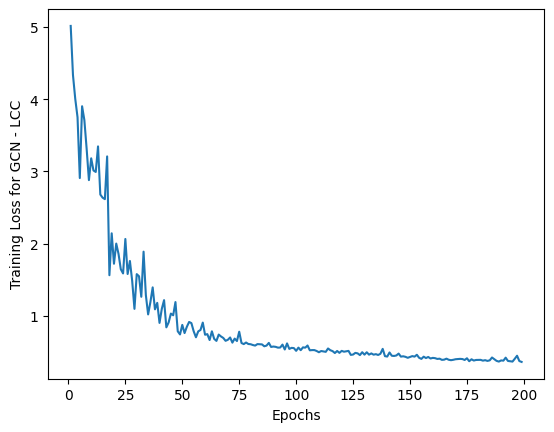

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, total_loss)
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.ylabel('Training Loss for GCN - LCC')
plt.show()

In [ ]:
micro_f1,macro_f1,macro_AUC_ROC,ap_score_1 = test(gat_model_lcc)
print("micro_f1:", micro_f1)
print("macro_f1:", macro_f1)
print("macro_AUC_ROC:", macro_AUC_ROC)
print("ap_score:", ap_score_1)

micro_f1: 0.32627986348122867
macro_f1: 0.08162655814171263
macro_AUC_ROC: 0.5006947857135537
ap_score: 0.09588107258423684


In [ ]:
model_normal = GCN(hidden_channels=32)
gat_model_normal = GAT(hidden_channels, num_heads)

In [ ]:
# decide which model to use
optimizer = torch.optim.Adam(gat_model_normal.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Train loop
epochs = list(range(1, 200))
total_loss = []
for epoch in epochs:
  loss = train_normal(gat_model_normal)
  total_loss.append(float(loss))
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 3.8486
Epoch: 002, Loss: 4.0510
Epoch: 003, Loss: 3.3676
Epoch: 004, Loss: 3.4345
Epoch: 005, Loss: 3.5500
Epoch: 006, Loss: 3.0704
Epoch: 007, Loss: 3.3979
Epoch: 008, Loss: 2.9759
Epoch: 009, Loss: 2.9273
Epoch: 010, Loss: 2.6825
Epoch: 011, Loss: 2.9229
Epoch: 012, Loss: 2.3600
Epoch: 013, Loss: 2.5877
Epoch: 014, Loss: 2.9150
Epoch: 015, Loss: 2.5201
Epoch: 016, Loss: 2.5920
Epoch: 017, Loss: 2.1676
Epoch: 018, Loss: 1.8695
Epoch: 019, Loss: 3.0423
Epoch: 020, Loss: 2.1271
Epoch: 021, Loss: 1.9107
Epoch: 022, Loss: 1.7858
Epoch: 023, Loss: 1.7432
Epoch: 024, Loss: 1.5429
Epoch: 025, Loss: 1.8126
Epoch: 026, Loss: 1.6501
Epoch: 027, Loss: 1.7424
Epoch: 028, Loss: 1.5548
Epoch: 029, Loss: 1.5041
Epoch: 030, Loss: 1.8827
Epoch: 031, Loss: 1.2633
Epoch: 032, Loss: 1.3017
Epoch: 033, Loss: 1.2035
Epoch: 034, Loss: 1.2976
Epoch: 035, Loss: 1.1627
Epoch: 036, Loss: 1.0577
Epoch: 037, Loss: 1.1338
Epoch: 038, Loss: 1.1873
Epoch: 039, Loss: 1.2438
Epoch: 040, Loss: 1.1938


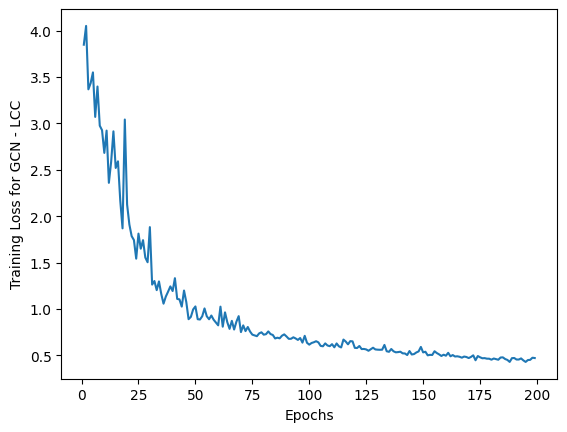

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, total_loss)
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.ylabel('Training Loss for GCN - LCC')
plt.show()

In [ ]:
micro_f1,macro_f1,macro_AUC_ROC,ap_score_1 = test(gat_model_normal)
print("micro_f1:", micro_f1)
print("macro_f1:", macro_f1)
print("macro_AUC_ROC:", macro_AUC_ROC)
print("ap_score:", ap_score_1)

micro_f1: 0.3508532423208191
macro_f1: 0.09420913257949878
macro_AUC_ROC: 0.4970697551350928
ap_score: 0.09642369281560982


In [ ]:
def list_difference(list1, list2):
    # 将列表转换为集合，方便计算差异
    set1 = set(list1)
    set2 = set(list2)
    # 计算两个集合的对称差
    difference = set1.symmetric_difference(set2)
    # 将结果转换为列表并返回
    return list(difference)

missing_label_index = list_difference(columns_count_lcc, list(range(HumLoc.y.shape[1])))
print(missing_label_index)

[]
